In [7]:
import umap 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn
import torch 
import torch_geometric as pyg 
import sklearn 


import sys 
sys.path.append('../../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset

from src.interpret.extract_entity_function import extract_entity_function
from src.interpret.GSNNExplainer import GSNNExplainer 
from src.interpret.plot_explanation_graph import plot_explanation_graph, plot_hairball

from src.prioritize.utils import get_base_X, dose2scale, set_drug_concs
from src.uncertainty.utils import root_mean_squared_picp_error, compute_picp, compute_ECE

from src.prioritize.utils import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#data = torch.load('../../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/Data.pt')
data = torch.load('../../output/SignalTransduction/FOLD-1/GSNN/c82456f4-6c84-4100-a83a-5d6d6d80b94d/Data.pt')
#model = torch.load('../../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/model-100.pt')
model = torch.load('../../output/SignalTransduction/FOLD-1/GSNN/c82456f4-6c84-4100-a83a-5d6d6d80b94d/model-100.pt')

siginfo = pd.read_csv('../../../data/siginfo_beta.txt', sep='\t', low_memory=False)

In [9]:
drugs = [x.split('__')[-1] for x in data.node_names if 'DRUG__' in x] # some 
cells = ['SKBR3']
doses = np.log(np.logspace(0.0,1.,10))

args = argparse.Namespace()
#args.proc = '../../output/exp1/proc/'
args.proc = '../../output/SignalTransduction/proc/'
args.combo = False
args.verbose = True

X, res = make_drug_inputs(args, data, drugs, cells, doses, siginfo)

screening 1661 drugs over 10 doses
screening 2-drug combination agents: False


KeyboardInterrupt: 

In [10]:
doses

array([0.        , 0.25584279, 0.51168558, 0.76752836, 1.02337115,
       1.27921394, 1.53505673, 1.79089952, 2.0467423 , 2.30258509])

In [ ]:
X.shape

torch.Size([16610, 13314])

In [ ]:

model = model.cuda().eval() 
Y = [] 
with torch.no_grad(): 

    for batch_idx in torch.split(torch.arange(len(X)), 100): 
        print(f'progress: {batch_idx[-1]}/{len(X)}', end='\r')
        xx = X[batch_idx].unsqueeze(-1).cuda() 

        yyhat = model(xx)[:, data.output_node_mask]
        Y.append(yyhat.cpu())

Y = torch.cat(Y, dim=0)

In [ ]:
Y.size()

torch.Size([16610, 541])

In [ ]:
reducer = umap.UMAP() 
u = reducer.fit_transform(Y.detach().cpu().numpy())

/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 180 with accuracies 
[1.08107677e-14 1.22320373e-05 7.87719963e-05 1.33523466e-05]
not reaching the requested tolerance 1.4603137969970703e-05.
Use iteration 127 instead with accuracy 
1.1702663269528543e-05.

  _, diffusion_map = lobpcg(
/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.14243900e-15 5.05294388e-06 1.41799605e-05 2.75777487e-05]
not reaching the requested tolerance 1.4603137969970703e-05.
  _, diffusion_map = lobpcg(


In [ ]:
res = res.assign(umap0= u[:,0], umap1=u[:,1]) 
res.head()

,cell_iname,pert_id_1,pert_id_2,dose_um_1,dose_um_2,umap0,umap1
0,SKBR3,BRD-A00077618,none,0.000000,0.0,4.832338,0.638697
1,SKBR3,BRD-A00077618,none,0.111111,0.0,8.644595,-11.078379
2,SKBR3,BRD-A00077618,none,0.222222,0.0,8.633325,-11.074053
3,SKBR3,BRD-A00077618,none,0.333333,0.0,8.632789,-11.075084
4,SKBR3,BRD-A00077618,none,0.444444,0.0,8.630416,-11.072892


In [ ]:
druginfo = pd.read_csv('../../../data/repurposing_drugs_20180907.txt', sep='\t', encoding='latin-1', skiprows=9).merge(pd.read_csv('../../../data/compoundinfo_beta.txt', sep='\t')[['pert_id', 'cmap_name']].drop_duplicates(), left_on='pert_iname', right_on='cmap_name')
druginfo.head()

,pert_iname,clinical_phase,moa,target,disease_area,indication,pert_id,cmap_name
0,A-366,Preclinical,histone lysine methyltransferase inhibitor,EHMT1|EHMT2,NaN,NaN,BRD-K06182768,A-366
1,A-61603,Preclinical,adrenergic receptor agonist,ADRA1A|ADRA1B|ADRA1D,NaN,NaN,BRD-A83650191,A-61603
2,A-7,Preclinical,calmodulin antagonist,NaN,NaN,NaN,BRD-K03301001,A-7
3,A-769662,Preclinical,AMPK activator,NaN,NaN,NaN,BRD-K41918892,A-769662
4,abacavir,Launched,nucleoside reverse transcriptase inhibitor,NaN,infectious disease,human immunodeficiency virus (HIV-1),BRD-A95032015,abacavir


In [ ]:
res = res.merge(druginfo, left_on='pert_id_1', right_on='pert_id', how='left')
res.head()

,cell_iname,pert_id_1,pert_id_2,dose_um_1,dose_um_2,umap0,umap1,pert_iname,clinical_phase,moa,target,disease_area,indication,pert_id,cmap_name
0,SKBR3,BRD-A00077618,none,0.000000,0.0,4.832338,0.638697,8-bromo-cGMP,Preclinical,PKA activator,PRKG1,NaN,NaN,BRD-A00077618,8-bromo-cGMP
1,SKBR3,BRD-A00077618,none,0.111111,0.0,8.644595,-11.078379,8-bromo-cGMP,Preclinical,PKA activator,PRKG1,NaN,NaN,BRD-A00077618,8-bromo-cGMP
2,SKBR3,BRD-A00077618,none,0.222222,0.0,8.633325,-11.074053,8-bromo-cGMP,Preclinical,PKA activator,PRKG1,NaN,NaN,BRD-A00077618,8-bromo-cGMP
3,SKBR3,BRD-A00077618,none,0.333333,0.0,8.632789,-11.075084,8-bromo-cGMP,Preclinical,PKA activator,PRKG1,NaN,NaN,BRD-A00077618,8-bromo-cGMP
4,SKBR3,BRD-A00077618,none,0.444444,0.0,8.630416,-11.072892,8-bromo-cGMP,Preclinical,PKA activator,PRKG1,NaN,NaN,BRD-A00077618,8-bromo-cGMP


210


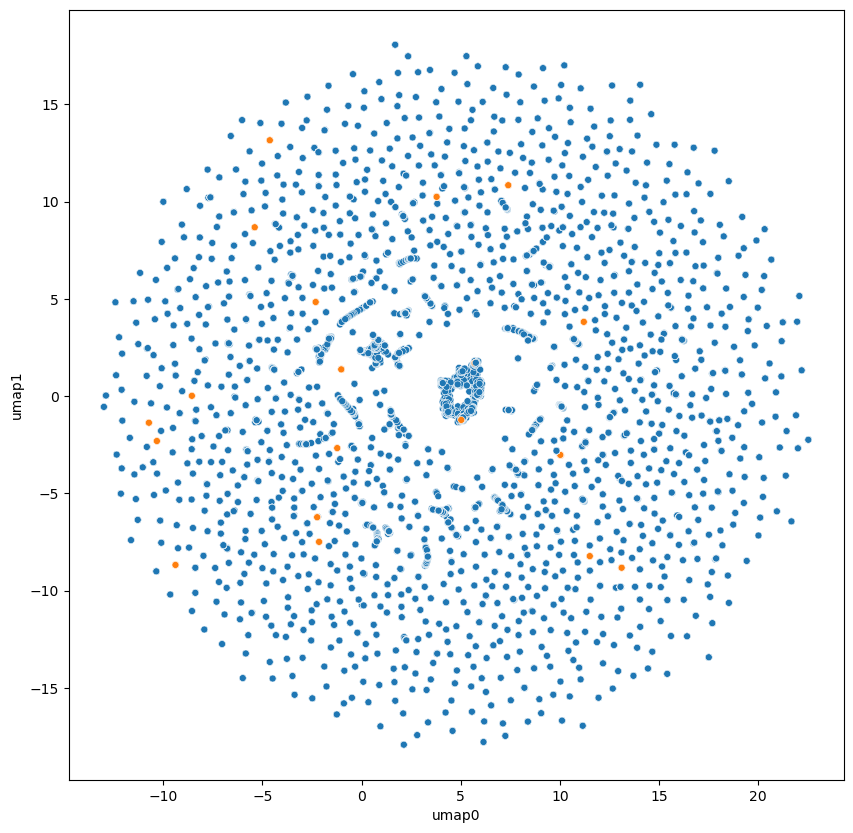

In [ ]:
#NSCLC_indication_colors = [1 if 'non-small cell lung cancer (NSCLC)' in str(x) else 0 for x in res.indication.values]
indication_colors = [1 if 'breast cancer' in str(x) else 0 for x in res.indication.values]

print(sum(indication_colors))
plt.figure(figsize=(10,10))
sbn.scatterplot(x='umap0', y='umap1', data=res, hue=indication_colors, legend=False, s=25, alpha=1.)
plt.show()

In [ ]:
dists = sklearn.metrics.pairwise_distances(res[['umap0', 'umap1']].values)
# dists = np.corrcoef(Y.detach().cpu().numpy())
#dists = sklearn.metrics.pairwise_distances(Y.detach().cpu().numpy())
#dists = pd.DataFrame(dists)
#dists.columns=res.cmap_name 
#dists.index=res.cmap_name

/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


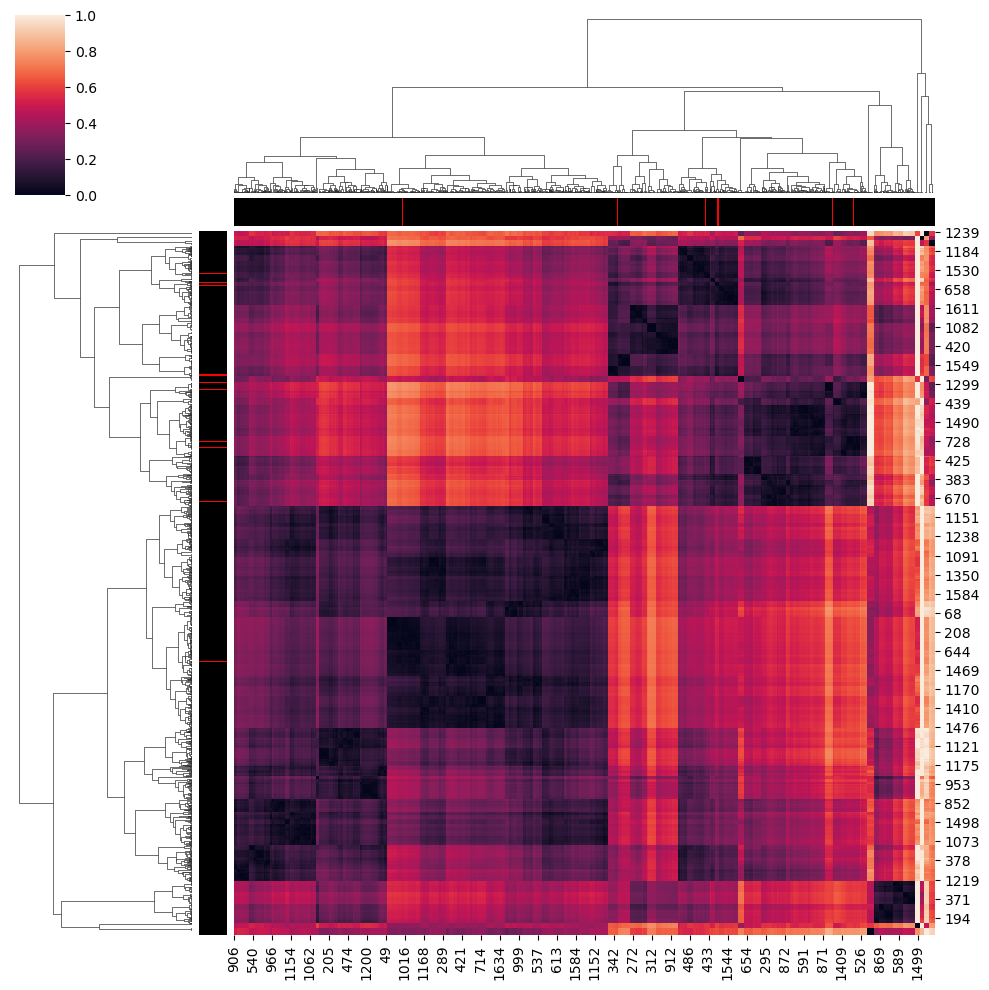

In [ ]:
#NSCLC_indication_colors = ['r' if x == 'non-small cell lung cancer (NSCLC)' else 'k' for x in res.indication.values]
indication_colors = ['r' if 'breast cancer' in str(x) else 'k' for x in res.indication.values]
sbn.clustermap(dists, standard_scale=False, row_colors=indication_colors, col_colors=indication_colors, figsize=(10,10), method='average')